# Analyse des Données Météorologiques de Météo-France liées aux Incendies (PACA & Nouvelle-Aquitaine)

### 1.Introduction

Ce notebook présente une analyse les données météorologiques issues de la réanalyse **"Données climatologiques de base - horaires"**, publiées par **Météo-France** et disponibles sur la plateforme officielle [meteo.data.gouv.fr](https://meteo.data.gouv.fr/datasets/6569b4473bedf2e7abad3b72).

Ces données, collectées à une fréquence horaire par les stations météorologiques, couvrent un large ensemble de variables climatiques, incluant notamment : la température de l’air, l’humidité relative, les précipitations, la vitesse et la direction du vent, la pression atmosphérique, le rayonnement solaire, etc.

### Contexte d’extraction et de préparation

Dans le cadre de ce projet, l’ensemble des enregistrements disponibles entre **2010 et 2025** a été téléchargé pour les départements concernés des régions **Nouvelle-Aquitaine** et **Provence-Alpes-Côte d’Azur (PACA)**.

Un important travail de **filtrage, de structuration et de mise en correspondance** a ensuite été réalisé, consistant à :
- associer chaque **événement d’incendie** à la **station météo la plus proche**, dans le même département ;
- extraire uniquement les observations correspondant aux **journées d’alerte** (entre 00h et 23h) pour chaque incendie ;
- enrichir les données météorologiques avec un identifiant unique `id_incendie`, assurant la traçabilité entre les deux jeux de données.

Ces étapes de traitement (filtrage, nettoyage, normalisation) ont été automatisées à l’aide de scripts Python, disponibles dans le répertoire suivant :  
`projet_incendies/scripts/Extraction_Traitement_Donnees/meteo_france`

### Objectifs du notebook

Ce notebook a pour objectif de **diagnostiquer la qualité, la complétude et la structure des données météorologiques** associées aux incendies, en vue de leur intégration dans des analyses descriptives, explicatives et prédictives.

Les objectifs spécifiques sont les suivants :

- **Évaluer la couverture temporelle et spatiale** des données météo pour chaque incendie ;
- **Mesurer les taux de valeurs manquantes** par variable et par événement ;
- **Identifier les variables les plus affectées par l'absence de données** afin d’envisager un traitement ou une exclusion ;
- **Nettoyer les enregistrements fortement incomplets ou entièrement vides**, pour garantir la fiabilité des futures analyses (modélisation, estimation des surfaces brûlées, etc.).

---


#### 2. Chargement des bibliothèques Python
Nous importons les bibliothèques nécessaires à l’analyse et à la visualisation :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### 3. Chargement des fichiers météo France (format CSV)
- `donnees_meteo_france_NA.csv` (Nouvelle-Aquitaine)
- `donnees_meteo_france_PACA.csv` (PACA)

In [2]:
df_na = pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\final\meteo_france\donnees_meteo_france_NA.csv", sep=";", encoding="utf-8-sig")
df_paca = pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\final\meteo_france\donnees_meteo_france_PACA.csv", sep=";", encoding="utf-8-sig")

In [3]:
print("Colonnes Nouvelle-Aquitaine :")
print(df_na.columns.tolist())
print("\n Colonnes PACA :")
print(df_paca.columns.tolist())

Colonnes Nouvelle-Aquitaine :
['id_incendie', 'id_station', 'nom_station', 'latitude', 'longitude', 'altitude_m', 'date_heure', 'precipitations_1h_mm', 'qualite_precipitations_1h', 'duree_precipitations_min', 'qualite_duree_precipitations', 'vent_moyen_10m_m_s', 'qualite_vent_moyen_10m', 'direction_vent_moyen_10m_deg', 'qualite_direction_vent_moyen_10m', 'vent_max_heure_10m_m_s', 'qualite_vent_max_heure_10m', 'direction_vent_max_heure_10m_deg', 'qualite_direction_vent_max_heure_10m', 'heure_vent_max_heure', 'qualite_heure_vent_max_heure', 'rafale_max_instantanee_10m_m_s', 'qualite_rafale_max_instantanee_10m', 'direction_rafale_max_instantanee_10m_deg', 'qualite_direction_rafale_max_instantanee_10m', 'heure_rafale_max_instantanee', 'qualite_heure_rafale_max', 'vent_moyen_2m_m_s', 'qualite_vent_moyen_2m', 'direction_vent_moyen_2m_deg', 'qualite_direction_vent_moyen_2m', 'rafale_max_instantanee_2m_m_s', 'qualite_rafale_max_instantanee_2m', 'direction_rafale_max_instantanee_2m_deg', 'quali

#### 5. Analyse de la qualité des colonnes

Dans cette section, nous sélectionnons uniquement les variables météorologiques pertinentes pour nos futures analyses. L’objectif est de diagnostiquer la qualité de ces colonnes, afin de filtrer les variables les plus exploitables.

La fonction utilisée permet de :

- Calculer le taux de valeurs manquantes pour chaque variable ;
- Extraire quelques exemples de valeurs observées ;
- Identifier les valeurs minimales et maximales (le cas échéant) ;
- Repérer les variables incomplètes, bruitées ou peu informatives.

Cette étape est essentielle pour garantir la robustesse des analyses statistiques et prédictives à venir.


In [ ]:
def analyse_qualite_colonnes(df, colonnes_utiles):
    rapport = []

    for col in colonnes_utiles:
        if col not in df.columns:
            continue  # ignorer colonnes absentes

        total = len(df)
        nb_nan = df[col].isna().sum()
        taux_nan = round(100 * nb_nan / total, 2)
        exemples = df[col].dropna().unique()[:5]
        min_val = df[col].min() if df[col].dtype != 'O' else None
        max_val = df[col].max() if df[col].dtype != 'O' else None

        rapport.append({
            "Colonne": col,
            "Taux NaN (%)": taux_nan,
            "Nb valeurs manquantes": nb_nan,
            "Min": min_val,
            "Max": max_val,
            "Exemples": exemples
        })

    return pd.DataFrame(rapport)

# Exemple d'exécution
colonnes_utiles = [
    # Identifiants
    "id_incendie", "id_station", "nom_station", "latitude", "longitude", "altitude_m", "date_heure",

    # Précipitations
    "precipitations_1h_mm",

    # Vent
    "vent_moyen_10m_m_s", "direction_vent_moyen_10m_deg",
    "vent_max_heure_10m_m_s", "rafale_max_instantanee_10m_m_s",
    "rafale_max_3s_m_s",

    # Températures
    "temperature_air_c", "temperature_min_air_c", "temperature_max_air_c",
    "temperature_sol_10cm_c", "temperature_min_surface_c",
    "point_de_rosee_c",

    # Humidité
    "humidite_relative_pourcent", "humidite_relative_min_pourcent",
    "duree_humidite_inf_40_pourcent_min", "duree_humidite_sup_80_pourcent_min",

    # Rayonnement et insolation
    "rayonnement_global_tsv_j_cm2", "indice_uv", "insolation_tsv_min",

    # Pression
    "pression_niveau_mer_hpa", "tension_vapeur_hpa",

    # Ciel & visibilité
    "nebulosite_totale_octa", "visibilite_m"
]
def tracer_taux_nan_horizontal(rapport, titre="Paramètres Météorologiques Incomplets pour la région"):
    rapport_filtré = rapport[rapport["Taux NaN (%)"] > 0].sort_values("Taux NaN (%)", ascending=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=rapport_filtré,
        y="Colonne",  # Horizontal → y = nom colonne
        x="Taux NaN (%)",
        color="skyblue"
    )

    plt.title(titre)
    plt.xlabel("Taux de valeurs manquantes (%)")
    plt.ylabel("Paramètres")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
# Lancer sur df_na et df_paca
rapport_na = analyse_qualite_colonnes(df_na, colonnes_utiles)
rapport_paca = analyse_qualite_colonnes(df_paca, colonnes_utiles)

#### 5. Analyse de la qualité des colonnes pour Nouvelle-Aquitaine

=== Qualité des colonnes NA ===


,Colonne,Taux NaN (%),Nb valeurs manquantes,Min,Max,Exemples
24,indice_uv,97.17,55658,0.000000e+00,9.000000e+00,"[0.0, 1.0, 2.0, 3.0, 4.0]"
28,nebulosite_totale_octa,94.19,53950,0.000000e+00,9.000000e+00,"[7.0, 6.0, 8.0, 2.0, 1.0]"
23,rayonnement_global_tsv_j_cm2,85.79,49138,0.000000e+00,3.480000e+02,"[0.0, 25.0, 83.0, 138.0, 201.0]"
29,visibilite_m,85.76,49123,6.500000e+01,6.000000e+04,"[31807.0, 26815.0, 25682.0, 27364.0, 23284.0]"
16,temperature_sol_10cm_c,84.86,48610,1.800000e+00,3.760000e+01,"[5.1, 5.0, 4.9, 4.8, 4.6]"
25,insolation_tsv_min,84.15,48201,0.000000e+00,6.000000e+01,"[0.0, 47.0, 60.0, 55.0, 54.0]"
26,pression_niveau_mer_hpa,83.02,47556,9.946000e+02,1.039700e+03,"[1028.3, 1028.4, 1028.5, 1028.1, 1027.7]"
12,rafale_max_3s_m_s,75.57,43286,0.000000e+00,3.220000e+01,"[3.5, 3.1, 1.7, 2.0, 1.5]"
17,temperature_min_surface_c,74.86,42879,-1.140000e+01,4.990000e+01,"[-0.8, -1.1, -1.4, -1.0, -0.9]"
10,vent_max_heure_10m_m_s,53.77,30802,0.000000e+00,1.940000e+01,"[3.8, 2.6, 1.2, 1.6, 1.3]"


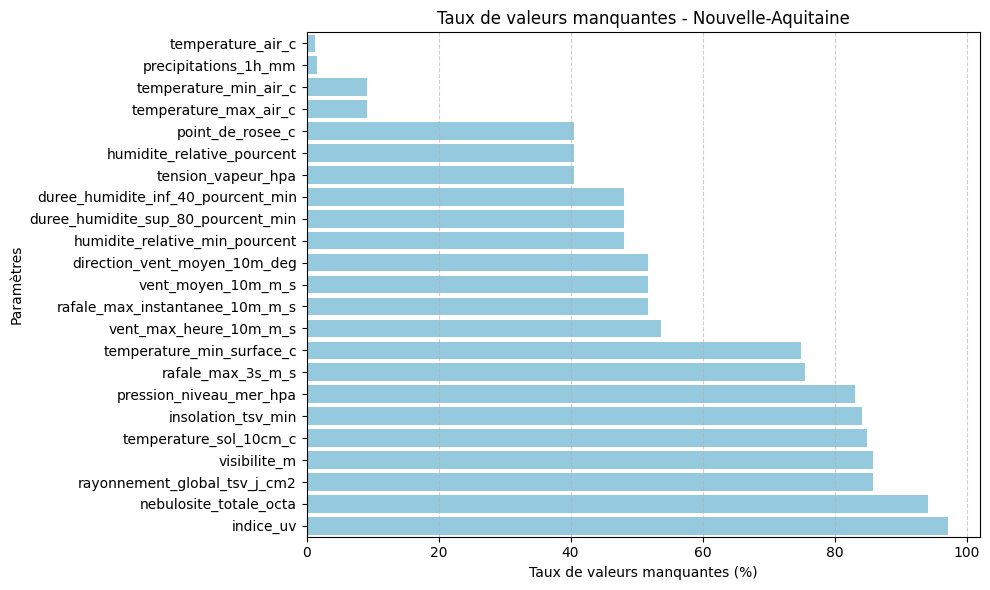

In [14]:
print("=== Qualité des colonnes NA ===")
display(rapport_na.sort_values("Taux NaN (%)", ascending=False))
tracer_taux_nan_horizontal(rapport_na, titre="Taux de valeurs manquantes - Nouvelle-Aquitaine")

Les données présentent un taux élevé de valeurs manquantes pour certaines variables :

- **`indice_uv`** : 97.2% manquants  
- **`nebulosite_totale_octa`** : 94.2%  
- **`rayonnement_global_tsv_j_cm2`** : 85.8%  
- **`temperature_sol_10cm_c`** : 84.9%  
- **`insolation_tsv_min`** : 84.1%  

Toutefois, certaines variables clés sont bien renseignées :
- **`temperature_air_c`** : 1.3% de valeurs manquantes  
- **`precipitations_1h_mm`** : 1.5%  
- **`temperature_min_air_c` / `temperature_max_air_c`** : ~9%  

> **Conclusion** : malgré l'absence de certaines variables secondaires, les données de NA permettent une analyse fiable des facteurs influençant les incendies.

---

#### 5. Analyse de la qualité des colonnes pour Provence-Alpes-Côte d'Azur


=== Qualité des colonnes PACA ===


,Colonne,Taux NaN (%),Nb valeurs manquantes,Min,Max,Exemples
24,indice_uv,99.88,116931,0.000000e+00,7.000000e+00,"[0.0, 1.0, 2.0, 4.0, 6.0]"
28,nebulosite_totale_octa,95.66,111989,0.000000e+00,9.000000e+00,"[2.0, 7.0, 3.0, 6.0, 1.0]"
16,temperature_sol_10cm_c,91.47,107092,1.200000e+00,3.960000e+01,"[14.1, 13.7, 13.4, 13.1, 12.8]"
23,rayonnement_global_tsv_j_cm2,90.41,105851,0.000000e+00,3.680000e+02,"[0.0, 9.0, 67.0, 133.0, 187.0]"
25,insolation_tsv_min,89.51,104795,0.000000e+00,6.000000e+01,"[0.0, 10.0, 60.0, 37.0, 52.0]"
29,visibilite_m,82.59,96697,6.700000e+01,9.000000e+04,"[40000.0, 20000.0, 70000.0, 90000.0, 50000.0]"
26,pression_niveau_mer_hpa,78.35,91734,9.966000e+02,1.038100e+03,"[1014.8, 1014.6, 1014.2, 1014.0, 1013.8]"
17,temperature_min_surface_c,64.72,75776,-9.800000e+00,5.380000e+01,"[6.5, 5.6, 5.5, 5.0, 4.4]"
12,rafale_max_3s_m_s,60.73,71102,0.000000e+00,4.020000e+01,"[1.6, 1.8, 1.4, 2.0, 2.1]"
21,duree_humidite_inf_40_pourcent_min,30.27,35444,0.000000e+00,6.000000e+01,"[0.0, 18.0, 60.0, 23.0, 41.0]"


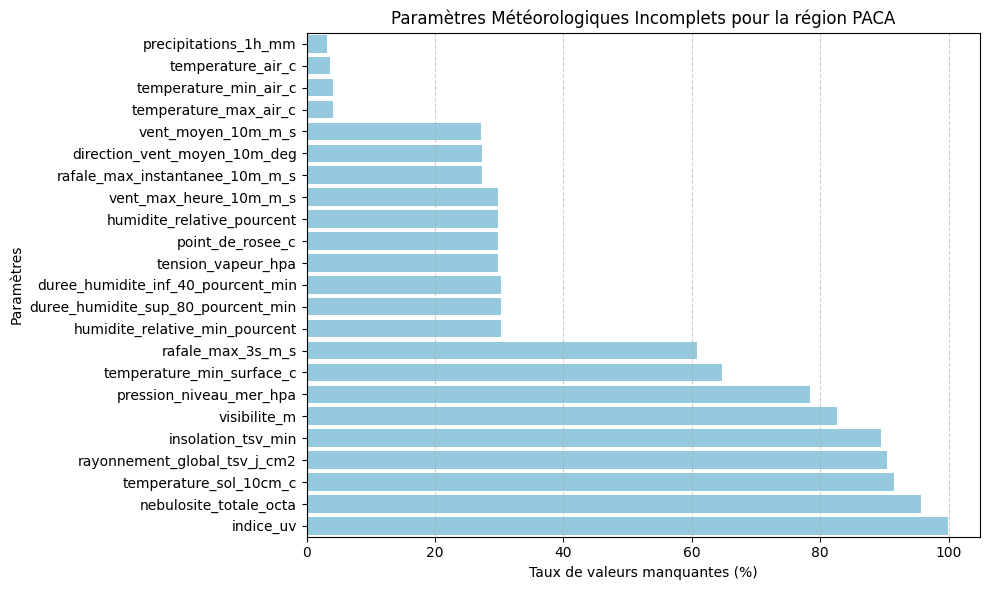

In [15]:
print("\n=== Qualité des colonnes PACA ===")
display(rapport_paca.sort_values("Taux NaN (%)", ascending=False))
tracer_taux_nan_horizontal(rapport_paca, "Paramètres Météorologiques Incomplets pour la région PACA")

Les données PACA montrent des tendances similaires, avec encore plus de valeurs manquantes pour certaines colonnes : 
- **`indice_uv`** : 99.9% manquants  
- **`nebulosite_totale_octa`** : 95.7%  
- **`temperature_sol_10cm_c`** : 91.5%  
- **`rayonnement_global_tsv_j_cm2`** : 90.4%  
- **`insolation_tsv_min`** : 89.5%  

Données essentielles bien remplies :
- **`temperature_air_c`** : 3.7%  
- **`precipitations_1h_mm`** : 3.3%  
- **`temperature_min_air_c` / `temperature_max_air_c`** : ~4%  
> **Conclusion** : les données de PACA sont suffisantes pour identifier les conditions climatiques critiques autour des incendies.

---


#### Paramètres météorologiques retenus pour l’analyse
[
    "temperature_air_c", "temperature_min_air_c", "temperature_max_air_c",
    "precipitations_1h_mm", "vent_moyen_10m_m_s", "direction_vent_moyen_10m_deg",
    "rafale_max_instantanee_10m_m_s", "vent_max_heure_10m_m_s",
    "humidite_relative_pourcent", "humidite_relative_min_pourcent",
    "duree_humidite_inf_40_pourcent_min", "duree_humidite_sup_80_pourcent_min",
    "point_de_rosee_c", "tension_vapeur_hpa"
]
#### Justification des paramètres sélectionnés

| **Paramètre**                                   | **Rôle dans les incendies**                                                                                      |
|-------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| Températures (air, min, max)                    | Indiquent le niveau de chaleur et la sécheresse de la végétation                                             |
| Précipitations                                    | Faible précipitation = sol sec = risque accru d'incendie                                                    |
| Vent (moyen, rafales, max)                       | Favorise l’extension rapide des feux et leur direction                                                      |
| Humidité relative (moy., min)                    | Faible humidité = atmosphère sèche favorable aux départs de feu                                             |
| Durée humidité < 40% / > 80%                     | Permet d’évaluer la persistance de conditions sèches ou humides                                             |
| Point de rosée                                   | Estimation de la saturation en vapeur d’eau de l’air, utile pour estimer la sécheresse                       |
| Tension de vapeur                                 | Complément d’analyse à l’humidité, reflète la capacité de l’air à contenir de la vapeur                      |

Ces variables sont reconnues dans la littérature scientifique comme étant les plus corrélées au risque incendie, tout en étant relativement bien renseignées dans les jeux de données NA et PACA.


#### 7. Filtrage des colonnes
On filtre les datasets pour ne conserver que les colonnes jugées utiles pour l’analyse finale.

In [6]:
# Liste des colonnes sélectionnées
colonnes_finales = [
    # Identifiants
    "id_incendie", "id_station", "nom_station", "latitude", "longitude", "altitude_m", "date_heure",

    # Précipitations
    "precipitations_1h_mm",

    # Vent
    "vent_moyen_10m_m_s", "direction_vent_moyen_10m_deg",
    "vent_max_heure_10m_m_s", "rafale_max_instantanee_10m_m_s",

    # Températures
    "temperature_air_c", "temperature_min_air_c", "temperature_max_air_c",

    # Humidité
    "humidite_relative_pourcent", "humidite_relative_min_pourcent",
    "duree_humidite_inf_40_pourcent_min", "duree_humidite_sup_80_pourcent_min",
    "point_de_rosee_c",

    # Pression
    "tension_vapeur_hpa",
]

# Filtrage des colonnes dans les deux DataFrames
df_na = df_na[colonnes_finales].copy()
df_paca = df_paca[colonnes_finales].copy()

# Vérification
print("Colonnes filtrées (NA) df_na :", df_na.columns.tolist())
print("Colonnes filtrées (PACA) df_paca :", df_paca.columns.tolist())


Colonnes filtrées (NA) df_na : ['id_incendie', 'id_station', 'nom_station', 'latitude', 'longitude', 'altitude_m', 'date_heure', 'precipitations_1h_mm', 'vent_moyen_10m_m_s', 'direction_vent_moyen_10m_deg', 'vent_max_heure_10m_m_s', 'rafale_max_instantanee_10m_m_s', 'temperature_air_c', 'temperature_min_air_c', 'temperature_max_air_c', 'humidite_relative_pourcent', 'humidite_relative_min_pourcent', 'duree_humidite_inf_40_pourcent_min', 'duree_humidite_sup_80_pourcent_min', 'point_de_rosee_c', 'tension_vapeur_hpa']
Colonnes filtrées (PACA) df_paca : ['id_incendie', 'id_station', 'nom_station', 'latitude', 'longitude', 'altitude_m', 'date_heure', 'precipitations_1h_mm', 'vent_moyen_10m_m_s', 'direction_vent_moyen_10m_deg', 'vent_max_heure_10m_m_s', 'rafale_max_instantanee_10m_m_s', 'temperature_air_c', 'temperature_min_air_c', 'temperature_max_air_c', 'humidite_relative_pourcent', 'humidite_relative_min_pourcent', 'duree_humidite_inf_40_pourcent_min', 'duree_humidite_sup_80_pourcent_min'

#### 8.Analyse des données manquantes après filtrage des variables météo
Nous avons évalué la complétude des données météo pour chaque incendie après avoir sélectionné les variables les plus pertinentes. L’analyse repose sur plusieurs étapes simples :

- **Calcul du taux de valeurs manquantes (NaN) par incendie.**
- **Définition de seuils de complétude** basés sur la distribution réelle des données.
- **Identification des cas exploitables** grâce à une visualisation claire des résultats.

Cette méthode permet de conserver les incendies disposant de données fiables tout en écartant les cas trop incomplets.


#### 8.1 Nouvelle-Aquaitaine

Distribution des données manquantes par incendie dans Nouvelle-Aquaitaine:


,Seuil (%),Nb Incendies,% Total
0,100.000000,498,16.4%
1,90.000000,502,16.6%
2,70.000000,1486,49.0%
3,50.000000,1712,56.4%
4,30.000000,1728,57.0%
5,10.000000,1847,60.9%
6,5.000000,1878,61.9%
7,1.000000,1896,62.5%


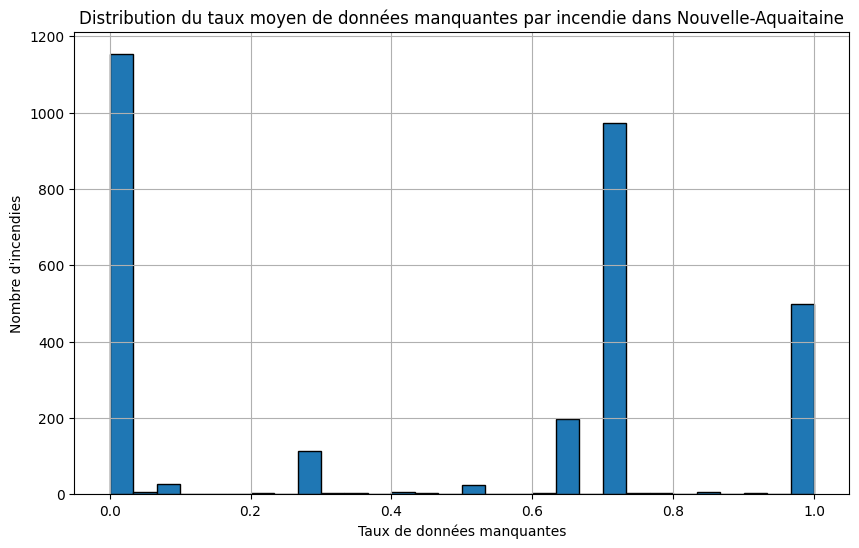


 Variables les plus manquantes:


,Taux de NaN
vent_max_heure_10m_m_s,0.537744
rafale_max_instantanee_10m_m_s,0.517947
vent_moyen_10m_m_s,0.517703
direction_vent_moyen_10m_deg,0.517703
humidite_relative_min_pourcent,0.481302
duree_humidite_inf_40_pourcent_min,0.481075
duree_humidite_sup_80_pourcent_min,0.481075
point_de_rosee_c,0.404626
tension_vapeur_hpa,0.404626
humidite_relative_pourcent,0.404557


In [28]:
# --- 1. Sélection des colonnes météo utiles ---
colonnes_meteo_utiles = [
    "temperature_air_c", "temperature_min_air_c", "temperature_max_air_c",
    "precipitations_1h_mm", "vent_moyen_10m_m_s", "direction_vent_moyen_10m_deg",
    "rafale_max_instantanee_10m_m_s", "vent_max_heure_10m_m_s",
    "humidite_relative_pourcent", "humidite_relative_min_pourcent",
    "duree_humidite_inf_40_pourcent_min", "duree_humidite_sup_80_pourcent_min",
    "point_de_rosee_c", "tension_vapeur_hpa"
]

# --- 2. Calcul des taux de NaN ---
df_nan_par_incendie = (
    df_na.groupby("id_incendie")[colonnes_meteo_utiles]
    .apply(lambda x: x.isna().mean())
    .assign(taux_nan_moyen=lambda x: x.mean(axis=1))
)

# --- 3. Analyse intelligente des seuils ---
def analyse_nan(taux_seuil):
    nb_incendies = (df_nan_par_incendie["taux_nan_moyen"] >= taux_seuil).sum()
    pourcentage = nb_incendies / len(df_nan_par_incendie) * 100
    return pd.Series({
        "Seuil (%)": taux_seuil*100,
        "Nb Incendies": nb_incendies,
        "% Total": f"{pourcentage:.1f}%"
    })

# Seuils adaptatifs basés sur la distribution réelle
seuils = [1.0, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.01]
resultats = pd.concat([analyse_nan(seuil) for seuil in seuils], axis=1).T

print("Distribution des données manquantes par incendie dans Nouvelle-Aquaitaine:")
display(resultats.style.background_gradient(cmap='Reds_r', subset=["Nb Incendies"]))

# --- 4. Visualisation ---
plt.figure(figsize=(10, 6))
df_nan_par_incendie["taux_nan_moyen"].hist(bins=30, edgecolor='black')
plt.title("Distribution du taux moyen de données manquantes par incendie dans Nouvelle-Aquaitaine")
plt.xlabel("Taux de données manquantes")
plt.ylabel("Nombre d'incendies")
plt.grid(True)
plt.show()

nan_par_variable = df_na[colonnes_meteo_utiles].isna().mean().sort_values(ascending=False)
print("\n Variables les plus manquantes:")
display(nan_par_variable.to_frame("Taux de NaN"))

#### Interprétation des Résultats – Nouvelle-Aquitaine

Les données présentent un taux élevé de valeurs manquantes pour les variables météorologiques critiques, notamment le vent (jusqu'à **53,8%** pour `vent_max_heure_10m_m_s`) et l'humidité (**48,1%** pour `humidite_relative_min_pourcent`). À l’inverse, les températures et précipitations sont bien renseignées (< **10%** de NaN).  

**Distribution des incendies par complétude des données :**  
- **16,4%** ont des données complètes (100% de valeurs renseignées).  
- **62,5%** présentent au moins **1%** de valeurs manquantes.  

**Conclusion** :
Une forte proportion de valeurs manquantes concernant des variables déterminantes pour la propagation du feu (vent, humidité).

#### 8.2. Provence-Alpes-Côte d'Azur

Distribution des données manquantes par incendie dans PACA:


,Seuil (%),Nb Incendies,% Total
0,100.000000,601,10.5%
1,90.000000,628,11.0%
2,70.000000,2048,35.7%
3,50.000000,2099,36.6%
4,30.000000,2133,37.2%
5,10.000000,2171,37.9%
6,5.000000,2280,39.8%
7,1.000000,2298,40.1%


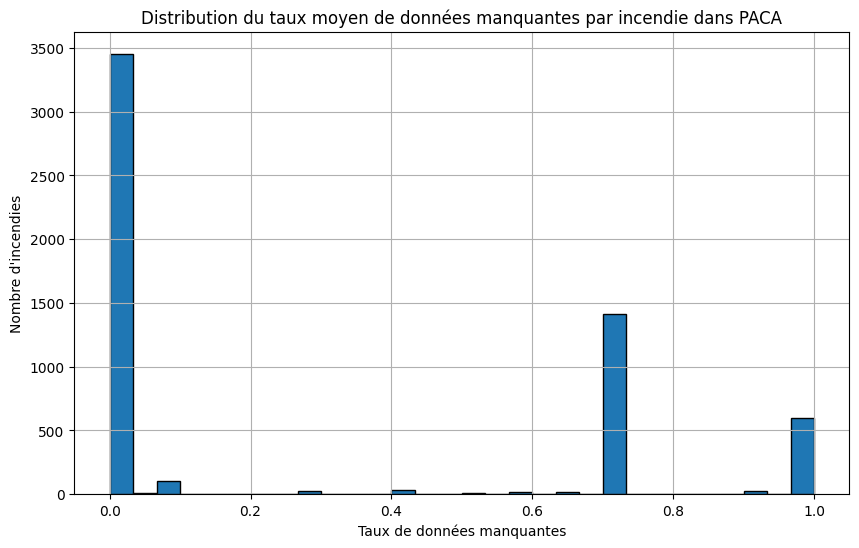


 Variables les plus manquantes:


,Taux de NaN
duree_humidite_inf_40_pourcent_min,0.302746
duree_humidite_sup_80_pourcent_min,0.302738
humidite_relative_min_pourcent,0.302678
point_de_rosee_c,0.297937
tension_vapeur_hpa,0.297937
humidite_relative_pourcent,0.297929
vent_max_heure_10m_m_s,0.297758
rafale_max_instantanee_10m_m_s,0.273790
direction_vent_moyen_10m_deg,0.272475
vent_moyen_10m_m_s,0.271604


In [29]:
# --- 1. Sélection des colonnes météo utiles ---
colonnes_meteo_utiles = [
    "temperature_air_c", "temperature_min_air_c", "temperature_max_air_c",
    "precipitations_1h_mm", "vent_moyen_10m_m_s", "direction_vent_moyen_10m_deg",
    "rafale_max_instantanee_10m_m_s", "vent_max_heure_10m_m_s",
    "humidite_relative_pourcent", "humidite_relative_min_pourcent",
    "duree_humidite_inf_40_pourcent_min", "duree_humidite_sup_80_pourcent_min",
    "point_de_rosee_c", "tension_vapeur_hpa"
]

# --- 2. Calcul des taux de NaN ---
df_nan_par_incendie = (
    df_paca.groupby("id_incendie")[colonnes_meteo_utiles]
    .apply(lambda x: x.isna().mean())
    .assign(taux_nan_moyen=lambda x: x.mean(axis=1))
)

# --- 3. Analyse intelligente des seuils ---
def analyse_nan(taux_seuil):
    nb_incendies = (df_nan_par_incendie["taux_nan_moyen"] >= taux_seuil).sum()
    pourcentage = nb_incendies / len(df_nan_par_incendie) * 100
    return pd.Series({
        "Seuil (%)": taux_seuil*100,
        "Nb Incendies": nb_incendies,
        "% Total": f"{pourcentage:.1f}%"
    })

# Seuils adaptatifs basés sur la distribution réelle
seuils = [1.0, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.01]
resultats = pd.concat([analyse_nan(seuil) for seuil in seuils], axis=1).T

print("Distribution des données manquantes par incendie dans PACA:")
display(resultats.style.background_gradient(cmap='Reds_r', subset=["Nb Incendies"]))

# --- 4. Visualisation ---
plt.figure(figsize=(10, 6))
df_nan_par_incendie["taux_nan_moyen"].hist(bins=30, edgecolor='black')
plt.title("Distribution du taux moyen de données manquantes par incendie dans PACA")
plt.xlabel("Taux de données manquantes")
plt.ylabel("Nombre d'incendies")
plt.grid(True)
plt.show()

# --- 5. Top 5 des variables les plus manquantes ---
nan_par_variable = df_paca[colonnes_meteo_utiles].isna().mean().sort_values(ascending=False)
print("\n Variables les plus manquantes:")
display(nan_par_variable.to_frame("Taux de NaN"))

#### Interprétation des Résultats – PACA

les incendies en PACA présentent des lacunes importantes sur les variables d'humidité (30% de NaN) et de vent (27-30%), tandis que les températures et précipitations sont mieux renseignées (<5% de NaN).
 
**Distribution des incendies par complétude des données :**  
- Seuls **10,5%** des incendies disposent de données complètes
- **40%** présentent au moins **1%** de valeurs manquantes

Comparativement à la Nouvelle-Aquitaine, la PACA montre un taux global de complétude légèrement supérieur, mais avec des disparités similaires sur les variables clés.

---

#### 9. Présence de valeurs manquantes par ligne
#### 9.1. Nouvelle-Aquaitaine 

In [ ]:
lignes_vides = df_na[colonnes_meteo_utiles].isna().any(axis=1)
nb_lignes_vides = lignes_vides.sum()
total_lignes = len(df_na)
taux_vides = nb_lignes_vides / total_lignes * 100

# --- 3. Résultat ---
print(f"Nombre total de lignes : {total_lignes}")
print(f"Lignes avec au moins une valeur NaN : {nb_lignes_vides}")
print(f"Taux de lignes incomplètes : {taux_vides:.2f}%")

Nombre total de lignes : 57280
Lignes avec au moins une valeur NaN : 31129
Taux de lignes incomplètes : 54.35%


#### 9.2. Provence-Alpes-Côte d'Azur

In [10]:
# --- 2. Calcul du taux de lignes avec au moins une valeur NaN ---
lignes_vides = df_paca[colonnes_meteo_utiles].isna().any(axis=1)
nb_lignes_vides = lignes_vides.sum()
total_lignes = len(df_paca)
taux_vides = nb_lignes_vides / total_lignes * 100

# --- 3. Résultat ---
print(f"Nombre total de lignes : {total_lignes}")
print(f"Lignes avec au moins une valeur NaN : {nb_lignes_vides}")
print(f"Taux de lignes incomplètes : {taux_vides:.2f}%")

Nombre total de lignes : 117075
Lignes avec au moins une valeur NaN : 38617
Taux de lignes incomplètes : 32.98%


#### 10. Suppression des lignes entièrement vides

Puisque de nombreuses lignes sont totalement vides et n'apportent aucune information utile, nous avons pris la décision de les supprimer afin d'améliorer la qualité des données et d'optimiser les traitements ultérieurs.


In [11]:
# --- Colonnes météo ciblées ---
colonnes_meteo_utiles = [
    "temperature_air_c", "temperature_min_air_c", "temperature_max_air_c",
    "precipitations_1h_mm", "vent_moyen_10m_m_s", "direction_vent_moyen_10m_deg",
    "rafale_max_instantanee_10m_m_s", "vent_max_heure_10m_m_s",
    "humidite_relative_pourcent", "humidite_relative_min_pourcent",
    "duree_humidite_inf_40_pourcent_min", "duree_humidite_sup_80_pourcent_min",
    "point_de_rosee_c", "tension_vapeur_hpa"
]

# --- Suppression des lignes 100% vides dans df_paca ---
nb_lignes_avant_paca = len(df_paca)
df_paca = df_paca.dropna(subset=colonnes_meteo_utiles, how='all')
nb_lignes_apres_paca = len(df_paca)

# --- Suppression des lignes 100% vides dans df_na ---
nb_lignes_avant_na = len(df_na)
df_na = df_na.dropna(subset=colonnes_meteo_utiles, how='all')
nb_lignes_apres_na = len(df_na)

# --- Résumé ---
print("=== Résumé nettoyage des lignes 100% NaN ===")
print(f"PACA : {nb_lignes_avant_paca - nb_lignes_apres_paca} lignes supprimées ({nb_lignes_avant_paca} : {nb_lignes_apres_paca})")
print(f"NA   : {nb_lignes_avant_na - nb_lignes_apres_na} lignes supprimées ({nb_lignes_avant_na} : {nb_lignes_apres_na})")


=== Résumé nettoyage des lignes 100% NaN ===
PACA : 624 lignes supprimées (117075 : 116451)
NA   : 510 lignes supprimées (57280 : 56770)


#### 11. Analyse de la qualité des colonnes après suppression des lignes entièrement vides

In [12]:
def analyse_qualite_colonnes(df, colonnes_utiles):
    rapport = []

    for col in colonnes_utiles:
        if col not in df.columns:
            continue  # ignorer colonnes absentes

        total = len(df)
        nb_nan = df[col].isna().sum()
        taux_nan = round(100 * nb_nan / total, 2)
        exemples = df[col].dropna().unique()[:5]
        min_val = df[col].min() if df[col].dtype != 'O' else None
        max_val = df[col].max() if df[col].dtype != 'O' else None

        rapport.append({
            "Colonne": col,
            "Taux NaN (%)": taux_nan,
            "Nb valeurs manquantes": nb_nan,
            "Min": min_val,
            "Max": max_val,
            "Exemples": exemples
        })

    return pd.DataFrame(rapport)

# Lancer sur df_na et df_paca
rapport_na = analyse_qualite_colonnes(df_na, colonnes_meteo_utiles )
rapport_paca = analyse_qualite_colonnes(df_paca, colonnes_meteo_utiles)

# Affichage
print("=== Qualité des colonnes NA ===")
display(rapport_na.sort_values("Taux NaN (%)", ascending=False))

print("\n=== Qualité des colonnes PACA ===")
display(rapport_paca.sort_values("Taux NaN (%)", ascending=False))

=== Qualité des colonnes NA ===


,Colonne,Taux NaN (%),Nb valeurs manquantes,Min,Max,Exemples
7,vent_max_heure_10m_m_s,53.36,30292,0.0,19.4,"[3.8, 2.6, 1.2, 1.6, 1.3]"
6,rafale_max_instantanee_10m_m_s,51.36,29158,0.0,35.3,"[3.6, 3.2, 1.7, 2.0, 1.5]"
4,vent_moyen_10m_m_s,51.34,29144,0.0,18.0,"[1.5, 0.0, 1.2, 0.7, 0.8]"
5,direction_vent_moyen_10m_deg,51.34,29144,0.0,360.0,"[100.0, 0.0, 260.0, 80.0, 130.0]"
9,humidite_relative_min_pourcent,47.66,27059,7.0,100.0,"[58.0, 62.0, 67.0, 71.0, 75.0]"
10,duree_humidite_inf_40_pourcent_min,47.64,27046,0.0,60.0,"[0.0, 40.0, 60.0, 44.0, 52.0]"
11,duree_humidite_sup_80_pourcent_min,47.64,27046,0.0,60.0,"[0.0, 3.0, 8.0, 20.0, 54.0]"
12,point_de_rosee_c,39.93,22667,-16.5,24.8,"[-1.4, -2.2, -1.7, -2.7, -0.5]"
13,tension_vapeur_hpa,39.93,22667,1.7,31.2,"[5.5, 5.2, 5.4, 5.0, 5.9]"
8,humidite_relative_pourcent,39.92,22663,7.0,100.0,"[62.0, 68.0, 71.0, 77.0, 81.0]"



=== Qualité des colonnes PACA ===


,Colonne,Taux NaN (%),Nb valeurs manquantes,Min,Max,Exemples
10,duree_humidite_inf_40_pourcent_min,29.90,34820,0.0,60.0,"[0.0, 18.0, 60.0, 23.0, 41.0]"
11,duree_humidite_sup_80_pourcent_min,29.90,34819,0.0,60.0,"[51.0, 60.0, 27.0, 0.0, 5.0]"
9,humidite_relative_min_pourcent,29.89,34812,6.0,100.0,"[75.0, 80.0, 81.0, 78.0, 83.0]"
8,humidite_relative_pourcent,29.42,34256,6.0,100.0,"[83.0, 81.0, 84.0, 82.0, 85.0]"
13,tension_vapeur_hpa,29.42,34257,0.4,30.7,"[3.1, 2.8, 3.0, 2.9, 3.3]"
12,point_de_rosee_c,29.42,34257,-32.6,24.5,"[-9.0, -10.3, -9.4, -9.9, -8.2]"
7,vent_max_heure_10m_m_s,29.40,34236,0.0,30.5,"[0.8, 1.0, 0.9, 1.2, 1.5]"
6,rafale_max_instantanee_10m_m_s,26.99,31430,0.0,49.2,"[1.6, 2.4, 1.5, 2.3, 2.0]"
5,direction_vent_moyen_10m_deg,26.86,31276,0.0,360.0,"[0.0, 40.0, 80.0, 170.0, 110.0]"
4,vent_moyen_10m_m_s,26.77,31174,0.0,28.4,"[0.0, 0.7, 0.8, 0.9, 0.6]"


#### **Analyse de la Qualité des Données Météorologiques (NA vs PACA)**

Après suppression des lignes entièrement vides, le taux de valeurs manquantes (NaN) diminue légèrement. Cependant, il n’est pas possible d’éliminer toutes ces lignes, car certaines variables essentielles comme les températures et les précipitations sont quasiment toujours renseignées, et ces données complètes sont précieuses pour les analyses ultérieures.

##### **Observations Principales par Région**

| Région                | Observations                                                                                     |
|----------------------|--------------------------------------------------------------------------------------------------|
| **Nouvelle-Aquitaine** | Forte proportion de valeurs manquantes, surtout sur les variables liées au vent (jusqu’à 53%) et à l’humidité (~40%). Les températures et précipitations sont relativement bien complètes (<10% NaN). |
| **PACA**              | Données globalement plus complètes, avec des taux de NaN plus faibles, notamment sur les paramètres de vent et humidité (environ 27-30%). Températures et précipitations également bien renseignées (<5%). |


### 12. conclusion 
Malgré cette disparité de qualité, les deux régions seront étudiées :

- **PACA** servira de base principale pour l’analyse, grâce à la meilleure complétude des données.
- **Nouvelle-Aquitaine** sera analysée partiellement, en se concentrant sur les périodes et variables où les données sont suffisamment complètes.

Cette approche garantit un compromis entre rigueur et exploitation maximale des données disponibles.

---

#### **Sauvegarde des fichiers nettoyés**
Les jeux de données finaux sont enregistrés dans des fichiers `.csv` prêts pour l’analyse descriptive.

In [14]:
chemin_na = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_meteo_nettoyes_na.csv"
chemin_paca = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_meteo_nettoyes_paca.csv"

# Sauvegarder les fichiers
df_na.to_csv(chemin_na, index=False, sep=";", encoding="utf-8-sig")
df_paca.to_csv(chemin_paca, index=False,sep=";", encoding="utf-8-sig")

print("Fichiers sauvegardés avec succès :")
print(f"- {chemin_na}")
print(f"- {chemin_paca}")

Fichiers sauvegardés avec succès :
- C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_meteo_nettoyes_na.csv
- C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_meteo_nettoyes_paca.csv
